In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nca import NeighborhoodComponentsAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

import statsmodels.formula.api as sm

In [2]:
actions = pd.read_csv("../../data/user16_vs_the_world.csv")
# actions = pd.read_csv("../../data/data.csv")
actions.head()

,traveled_distance_pixel,elapsed_time,straightness,num_points,sum_of_angles,mean_curv,sd_curv,max_curv,min_curv,mean_omega,...,action_3,action_4,direction_1,direction_2,direction_3,direction_4,direction_5,direction_6,direction_7,user_16
0,7.000000,0.125,1.000000,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,1
1,89.008474,0.437,0.999968,5,0.016948,-0.000634,0.001366,0.000287,-0.002825,0.009086,...,0,0,0,0,0,0,0,0,0,1
2,3.000000,0.125,1.000000,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,1
3,1051.510748,3.369,0.310032,29,12.039747,0.060570,0.315803,1.570796,-0.397340,0.563722,...,1,0,0,0,0,0,0,0,0,1
4,42.000000,0.390,1.000000,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1


In [3]:
actions.columns

Index(['traveled_distance_pixel', 'elapsed_time', 'straightness', 'num_points',
       'sum_of_angles', 'mean_curv', 'sd_curv', 'max_curv', 'min_curv',
       'mean_omega', 'sd_omega', 'max_omega', 'min_omega', 'largest_deviation',
       'dist_end_to_end_line', 'num_critical_points', 'mean_vx', 'sd_vx',
       'max_vx', 'min_vx', 'mean_vy', 'sd_vy', 'max_vy', 'min_vy', 'mean_v',
       'sd_v', 'max_v', 'min_v', 'mean_a', 'sd_a', 'max_a', 'min_a',
       'mean_jerk', 'sd_jerk', 'max_jerk', 'min_jerk', 'a_beg_time',
       'action_3', 'action_4', 'direction_1', 'direction_2', 'direction_3',
       'direction_4', 'direction_5', 'direction_6', 'direction_7', 'user_16'],
      dtype='object')

In [4]:
corr = actions.corr()

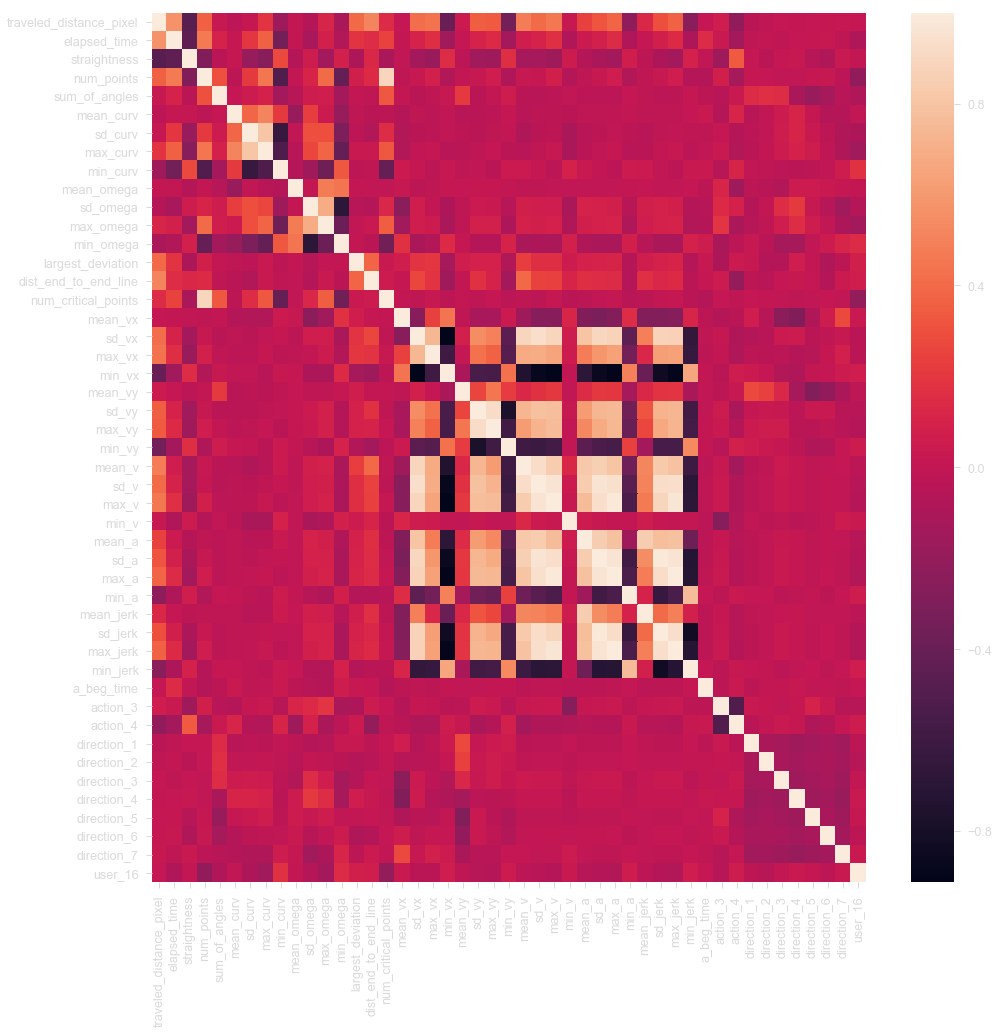

In [55]:
plt.figure(figsize=(16,16))
sns.heatmap(corr)
plt.savefig('heatmap.png')
plt.show()

In [6]:
columns = np.full((corr.shape[0],), True, dtype=bool)

In [7]:
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if (corr.iloc[i, j] >= 0.8) | (corr.iloc[i, j] <= -0.8):
            if columns[j]:
                columns[j] = False

In [8]:
selected_columns = actions.columns[columns]

In [9]:
actions = actions[selected_columns]

In [10]:
selected_columns = selected_columns[:-1].values

In [11]:
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

In [12]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(actions.drop("user_16", axis=1).values,
                                                     actions["user_16"].values,
                                                     SL,
                                                     selected_columns)

In [13]:
new_data = pd.DataFrame(data=data_modeled, columns=selected_columns)

In [14]:
# split into features and target variable

norm_data = normalize(new_data)

X_train, X_test, y_train, y_test = train_test_split(norm_data, actions["user_16"], test_size=0.3,
                                                    random_state=42)

# Neighborhood Components Analysis

In [15]:
nca = NeighborhoodComponentsAnalysis(random_state=42, n_components=2)

In [16]:
nca.fit(X_train, y_train)

NeighborhoodComponentsAnalysis(callback=None, init='auto', max_iter=50,
                               n_components=2, random_state=42, tol=1e-05,
                               verbose=0, warm_start=False)

In [31]:
param_grid = {"n_neighbors": np.arange(1, 1000, 2),
              "weights": ["uniform", "distance"]}

In [32]:
gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1)

In [33]:
gs.fit(nca.transform(X_train), y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 870 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1670 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2220 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2870 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 3620 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 4470 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 17.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  6...
       885, 887, 889, 891, 893, 895, 897, 899, 901, 903, 905, 907, 909,
       911, 913, 915, 917, 919, 921, 923, 925, 927, 929, 931, 933, 935,
       937, 939, 941, 943, 945, 947, 949, 951, 953, 955, 957, 959, 961,
       963, 965, 967, 969, 971, 973, 975, 977, 979, 981, 983, 985, 987,
       989, 991, 993, 995, 997, 999]),
   

In [34]:
gs.best_params_

{'n_neighbors': 281, 'weights': 'uniform'}

In [35]:
pred = gs.predict(nca.transform(X_test))

In [36]:
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.70      0.36      0.47      3214
           1       0.57      0.85      0.68      3247

    accuracy                           0.60      6461
   macro avg       0.64      0.60      0.58      6461
weighted avg       0.64      0.60      0.58      6461

[[1149 2065]
 [ 490 2757]]


In [49]:
k = gs.best_params_["n_neighbors"]

In [40]:
clf = KNeighborsClassifier(n_neighbors=k, weights="distance")

In [45]:
x = nca.transform(X_train)
y = np.array(y_train)

In [43]:
clf.fit(x, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=281, p=2,
                     weights='distance')

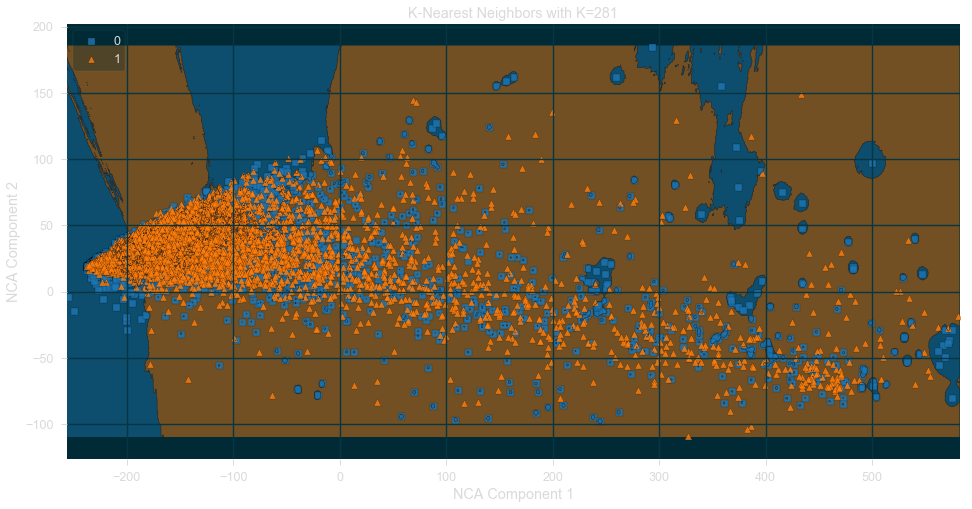

In [54]:
plt.figure(figsize=(16,8))
plot_decision_regions(x, y, clf=clf, legend=2)
plt.xlabel("NCA Component 1")
plt.ylabel("NCA Component 2")
plt.title("K-Nearest Neighbors with K="+str(k))
plt.savefig('KNN_281.png')
plt.show()